### Label-Free Supervision of Neural Networks with Physics and Domain Knowledge
不使用 label， 只是将物理规律编码到损失函数，就可以学出目标，下面是我的一个简单demo，验证这种方案。
首先构造一个数据集，每个数据集是一系列的向量，每一个向量只有一维不是0，我希望模型学到这个非0值的下标的相对值。

In [242]:
import numpy as np
def gen_data(n_samples, dim=10):
    X = np.zeros((n_samples, dim))
    for i in range(n_samples):
        if i < dim:
            X[i, i] = 0.1 + np.random.rand()
        else:
            X[i, i% dim] = 0.1 + np.random.rand()
    return X

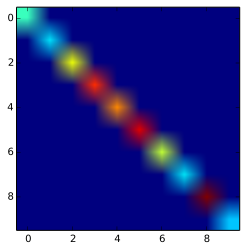

In [235]:
import matplotlib.pyplot as plt 
plt.imshow(gen_data(10))

利用 TensorFlow 构造模型，希望模型对每一个batch学到的输出是一个线性函数，将输出映射为[0,1]。

In [3]:
import tensorflow as tf
import keras
sess = tf.Session()

Using TensorFlow backend.


In [163]:
x = tf.placeholder(tf.float32, shape=(10,10))
w1 = tf.Variable(name='nn_w1', initial_value=np.random.randn(10, 10) * np.sqrt(2/10.0), dtype=tf.float32)
a1 = tf.nn.tanh(tf.matmul(x, w1))
w2 = tf.Variable(name='nn_w2', initial_value=np.random.randn(10, 1) * np.sqrt(2/10.0), dtype=tf.float32)
y = tf.matmul(a1, w2)

In [164]:
yv = tf.reshape(y, (10,))

将模型预测的结果做线性拟合，损失函数第一项即为拟合残差，第二项是输出结果的负方差，防止学到平凡解（恒为0的解），第三项是限制输出在[0,1]内，对超出这个范围的值作惩罚。

模型是一个单隐层的神经网络，隐层激活函数用的是 `tanh` ，利用 Adam 算法优化。
从结果来看，模型很好地学到了这个线性关系。输入是一个10维向量，且满足

$$
x_i>0 \quad \text{and} \quad x_j=0,j \ne i
$$

待学习的映射关系是

$$
f(x) =    \frac{i}{10}, x_i>0 \quad \text{and}\quad x_j=0,j \ne i
$$

In [165]:
iv = tf.constant(np.array(range(10)), dtype=tf.float32)
a = 0.1
b = tf.reduce_mean(yv) - a * 4.5
yhat = a*iv + b
loss = tf.reduce_mean((yhat - yv) * (yhat - yv)) - 0.1 * tf.reduce_mean((yv - tf.reduce_mean(yv)) * (yv - tf.reduce_mean(yv))) \
        + 0.2 * (tf.reduce_max(tf.nn.relu(y - 1)) + tf.reduce_max(tf.nn.relu(-y)))

In [206]:
optimizer = tf.train.AdamOptimizer(1e-3)
train_op = optimizer.minimize(loss)

In [257]:
init = tf.global_variables_initializer()
sess.run(init)

In [258]:
for step in xrange(50000):
    _, loss_val = sess.run([train_op, loss], feed_dict={x : gen_data(10)})
    if step % 1000 == 0:
        print '\r[%d] Loss: %f' % (step, loss_val) ,

[49000] Loss: -0.008657


修改`n=15`可以看到确实是学到的意义映射关系，而非输出一条直线。

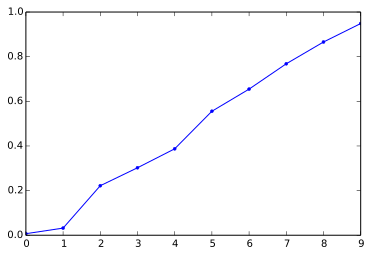

In [264]:
n = 10
plt.plot(sess.run(y, feed_dict={x : gen_data(n)[-10:]}), '.-')

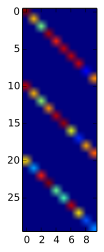

In [251]:
plt.imshow(gen_data(30))